In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

import matplotlib as mpl

In [2]:

#fitType = 'bin center approximation'
fitType = 'integral within bin'





rcond_val = 0.001

diagonal_constant = 1.0



use_uniform_fit_hist_binning = True


uniform_fit_hist_nbins = 20
uniform_fit_hist_xlow = -3.
uniform_fit_hist_xhigh = 3.


In [3]:
input_dir = 'hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform'

ndim = 1


In [4]:
sample_input_dir = cu.get_par( '%s/config.txt' % input_dir, 'input_dir')
print('  sample_input_dir = %s' % sample_input_dir )

true_mu = np.zeros( shape=(ndim))
true_cov = np.zeros( shape=(ndim,ndim) )
true_sig = np.zeros( shape=(ndim))

pv = cu.get_par( '%s/config.txt' % sample_input_dir,'mu_true')
true_mu[0] = float(pv)

pv = cu.get_par( '%s/config.txt' % sample_input_dir,'var_true')
true_cov[0,0] = float(pv)
true_sig[0] = np.sqrt(float(pv))


  sample_input_dir = input-samples-smearing-0.75-v1b


In [5]:
n_samples = 0

for fi in range(5000) :
    
    fname = '%s/sample-%04d.npy' % (sample_input_dir, fi)
    
    if exists(fname) :
        n_samples = n_samples + 1
        
print("\n\n Found %d samples.\n\n" % n_samples )



 Found 500 samples.




In [6]:
def read_sample( input_dir, sample_index ) :
    
    with open( '%s/sample-%04d.npy' % (input_dir, sample_index), 'rb' ) as f :
        read_true_pts = np.load(f)
        read_true_det_pts = np.load(f)
        read_train_pts = np.load(f)
        read_train_det_pts = np.load(f)

    ngen_true = len(read_true_pts)
    ngen_train = len(read_train_pts)

    this_ngen_true = ngen_true

    #-- package these in the same format as what I was using.

    true_pts = np.zeros( shape=(ngen_true,1) )
    true_pts[:,0] = read_true_pts

    true_det_pts = np.zeros( shape=(ngen_true,1) )
    true_det_pts[:,0] = read_true_det_pts

    train_pts = np.zeros( shape=(ngen_train,1) )
    train_pts[:,0] = read_train_pts

    train_det_pts = np.zeros( shape=(ngen_train,1) )
    train_det_pts[:,0] = read_train_det_pts
    
    return_dict = {}
    
    return_dict['true_pts'] = true_pts
    return_dict['true_det_pts'] = true_det_pts
    return_dict['train_pts'] = train_pts
    return_dict['train_det_pts'] = train_det_pts
    return_dict['ngen_true'] = ngen_true
    return_dict['ngen_train'] = ngen_train
    
    return return_dict
    
    

## Calculate the model parameters from simple average and covariance from weighted events

In [7]:
def calc_mean_cov( weights, fi1, fi2 ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * train_pts[:,fi1] )
    wx2 = np.sum( weights * train_pts[:,fi2] )
    wx1x2 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi1] )
        wx2x2 = np.sum( weights * train_pts[:,fi2] * train_pts[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [8]:
%%time

all_mean = np.zeros( shape=(ndim,n_samples) )
all_rms = np.zeros( shape=(ndim,n_samples) )
all_cov = np.zeros( shape=(ndim,ndim,n_samples) )
all_rho = np.zeros( shape=(ndim,ndim,n_samples) )

all_weight_min = np.zeros( n_samples )
all_weight_max = np.zeros( n_samples )

all_weight_sum = np.zeros( n_samples )


si = 0

for fi in range(n_samples) :
    
    rd = read_sample( sample_input_dir, fi )

    ngen_true = rd['ngen_true']
    ngen_train = rd['ngen_train']

    true_pts = rd['true_pts']
    true_det_pts = rd['true_det_pts']
    train_pts = rd['train_pts']
    train_det_pts = rd['train_det_pts']
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        
        print('\n----- %s exists' % fname )
        
        with open(fname,'rb') as f :
            
            final_push_weights_scaled = np.load(f)
            
        print( len(final_push_weights_scaled))
        print( final_push_weights_scaled )
        print( true_pts[:,0])

        all_weight_min[si] = np.min( final_push_weights_scaled )
        all_weight_max[si] = np.max( final_push_weights_scaled )

        all_weight_sum[si] = np.sum( final_push_weights_scaled )

        for fi1 in range(ndim) :
            for fi2 in range(fi1,ndim) :
                mean_cov = calc_mean_cov( final_push_weights_scaled, fi1, fi2 )
                all_cov[fi1,fi2,si] = mean_cov["cov_x1x2"]
                all_cov[fi2,fi1,si] = mean_cov["cov_x1x2"]
                if ( fi1 == fi2 ) :
                    print( "  %d %d  :  mean = %8.4f, RMS = %8.4f, cov = %8.4f" % 
                          (fi1, fi2, mean_cov["mean_x1"], mean_cov["rms1"], mean_cov["cov_x1x2"]))
                    all_mean[fi1,si] = mean_cov["mean_x1"]
                    all_rms[fi1,si] = mean_cov["rms1"]
                else :
                    print( "  %d %d  :  rho = %8.4f,  cov = %8.4f" %
                          (fi1, fi2, mean_cov["rho12"], mean_cov["cov_x1x2"]) )
                    all_rho[fi1,fi2,si] = mean_cov["rho12"]
                    all_rho[fi2,fi1,si] = mean_cov["rho12"]
                        
        si = si + 1
        
            


----- hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/bootstrap-weights-000.npy exists
100000
[0.112323   0.0971536  0.11644869 ... 0.11127081 0.04574313 0.06292559]
[ 1.01885404  1.01839928 -2.32279647 ...  0.47728579 -0.97300707
  1.30106692]
  0 0  :  mean =   0.1922, RMS =   0.9210, cov =   0.8483

----- hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/bootstrap-weights-001.npy exists
100000
[0.1185856  0.1113945  0.11069318 ... 0.11808441 0.08507084 0.09656268]
[-0.05077877  0.58599223 -1.30575318 ...  1.24571705 -0.49659518
  0.43982423]
  0 0  :  mean =   0.1755, RMS =   0.9152, cov =   0.8377

----- hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/bootstrap-weights-002.npy exists
100000
[0.10265368 0.05805157 0.10821195 ... 0.05061074 0.07385811 0.08040215]
[ 0.81392092  0.35421215  0.10291288 ... -0.83746416 -0.49381886
  0.18003886]
  0 0  :  mean =   0.1867, RMS =   0.9158, cov =   0.8386

----- hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/boots

100000
[0.11710646 0.08783096 0.08530693 ... 0.13032168 0.10048599 0.06594575]
[-0.39181246  0.17015079  0.56828577 ...  0.17718298 -0.96983195
 -0.77176073]
  0 0  :  mean =   0.2046, RMS =   0.8989, cov =   0.8079

----- hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/bootstrap-weights-122.npy exists
100000
[0.12058091 0.05667612 0.08669188 ... 0.12514075 0.08669188 0.07568679]
[-0.22846938  1.44843721  0.87927949 ...  0.01890761  1.07991266
 -0.82913122]
  0 0  :  mean =   0.2044, RMS =   0.9142, cov =   0.8358

----- hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/bootstrap-weights-123.npy exists
100000
[0.12172836 0.0891482  0.12258091 ... 0.12180496 0.11200169 0.10088018]
[-1.26316501  1.27642818  1.22749478 ...  1.17225959 -0.01451817
 -0.16897115]
  0 0  :  mean =   0.2091, RMS =   0.9193, cov =   0.8451

----- hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/bootstrap-weights-124.npy exists
100000
[0.11860707 0.06778591 0.09463508 ... 0.1080667  0.07804425 

  0 0  :  mean =   0.1830, RMS =   0.9048, cov =   0.8187

----- hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/bootstrap-weights-269.npy exists
100000
[0.06795221 0.11533985 0.11741846 ... 0.07728879 0.11933475 0.11791976]
[-2.30596928  0.41102309  0.54266471 ...  1.30399686 -0.92363115
 -1.09369445]
  0 0  :  mean =   0.1772, RMS =   0.9066, cov =   0.8219

----- hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/bootstrap-weights-270.npy exists
100000
[0.11430427 0.12838509 0.06667915 ... 0.05461868 0.07499848 0.12916756]
[ 0.83999216 -0.19732985  1.39981619 ... -0.19800231  1.91741697
  0.33530534]
  0 0  :  mean =   0.2261, RMS =   0.9009, cov =   0.8117

----- hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/bootstrap-weights-271.npy exists
100000
[0.08524969 0.11452815 0.11657255 ... 0.04801899 0.11012213 0.12014292]
[0.33496196 0.27610812 0.55029556 ... 0.87799468 1.25366119 0.92864471]
  0 0  :  mean =   0.2074, RMS =   0.9285, cov =   0.8621

----- hist-pdf-

  0 0  :  mean =   0.1955, RMS =   0.9068, cov =   0.8223

----- hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/bootstrap-weights-417.npy exists
100000
[0.12390532 0.11727958 0.0694223  ... 0.1173831  0.06409233 0.09784231]
[-1.89449733  0.00272023 -1.22093758 ...  1.45583959  0.80522628
 -0.7384637 ]
  0 0  :  mean =   0.2012, RMS =   0.9154, cov =   0.8380

----- hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/bootstrap-weights-418.npy exists
100000
[0.11654817 0.10670059 0.09476145 ... 0.10500353 0.10378312 0.08308807]
[ 1.4599773   1.17374847 -1.06098898 ...  0.04012425  0.0531916
  1.36912283]
  0 0  :  mean =   0.1922, RMS =   0.9053, cov =   0.8196

----- hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/bootstrap-weights-419.npy exists
100000
[0.07934891 0.06710507 0.10411197 ... 0.05978515 0.07698511 0.09240735]
[-0.39033841  1.40743863 -0.56338427 ...  0.06517813 -0.18580045
  1.71686137]
  0 0  :  mean =   0.2018, RMS =   0.8982, cov =   0.8067

----- his

<function matplotlib.pyplot.show(close=None, block=None)>

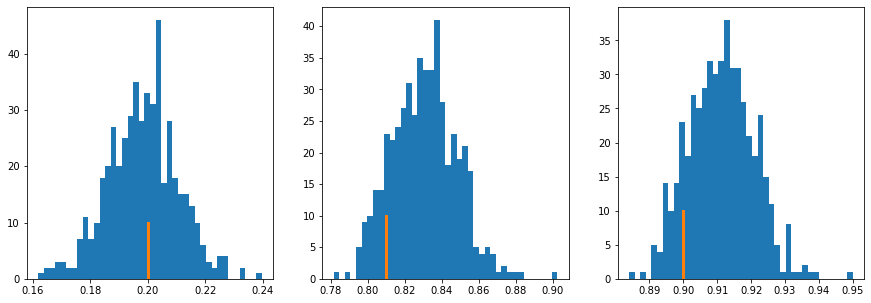

In [9]:
fig,ax = plt.subplots( ndim, 3, figsize=(3*5,ndim*5))

ymax = 10

for i in range(ndim) :
    
    if ndim > 1 :
        thisax = ax[i][0]
    else :
        thisax = ax[0]
    thisax.hist( all_mean[i], bins=40)
    thisax.plot( (true_mu[i], true_mu[i]), (0,ymax), linewidth=3 )
    
    if ndim > 1 :
        thisax = ax[i][1]
    else :
        thisax = ax[1]    
    thisax.hist( all_cov[i][i], bins=40)
    thisax.plot( (true_cov[i][i], true_cov[i][i]), (0,ymax), linewidth=3 )


    
    if ndim > 1 :
        thisax = ax[i][2]
    else :
        thisax = ax[2]    
    thisax.hist( all_rms[i], bins=40)
    thisax.plot( (true_sig[i], true_sig[i]), (0,ymax), linewidth=3 )    
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

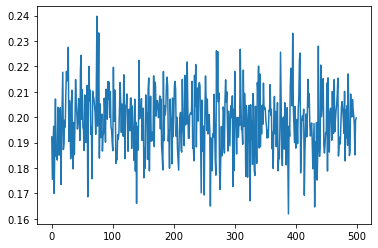

In [10]:
plt.plot(all_mean[0])
plt.show

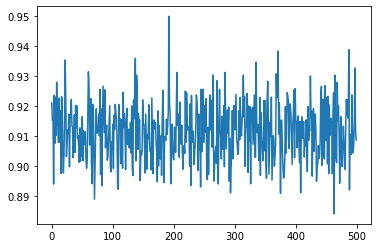

In [11]:
plt.plot(all_rms[0])

<function matplotlib.pyplot.show(close=None, block=None)>

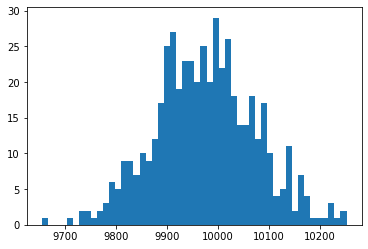

In [12]:
plt.hist( all_weight_sum, bins=50 )
plt.show

In [13]:
print( 'Weight sum RMS: %.1f' % np.sqrt( np.cov(all_weight_sum)))

Weight sum RMS: 98.8


In [14]:
print('\n')

ave_mean = np.zeros( ndim )
rms_mean = np.zeros( ndim )
rms_mean_err = np.zeros( ndim )

ave_cov = np.zeros( shape=(ndim,ndim) )
rms_cov = np.zeros( shape=(ndim,ndim) )
rms_cov_err = np.zeros( shape=(ndim,ndim) )


for fi in range(ndim) :
    
    ave_mean[fi] = np.mean( all_mean[fi] )
    ave_mean2 = np.mean( all_mean[fi]*all_mean[fi])
    rms_mean[fi] = np.sqrt( ave_mean2 - ave_mean[fi]*ave_mean[fi] )
    rms_mean_err[fi] = rms_mean[fi] / np.sqrt(2*n_samples)
    print("  feature %d  :  mean   ave %8.4f  (true %8.4f), rms %8.5f +/- %6.5f" % 
          (fi, ave_mean[fi], true_mu[fi], rms_mean[fi], rms_mean_err[fi] ))
    
print('\n')

for fi in range(ndim) :
    
    ave_rms = np.mean( all_rms[fi] )
    ave_rms2 = np.mean( all_rms[fi]*all_rms[fi])
    rms_rms = np.sqrt( ave_rms2 - ave_rms*ave_rms )
    print("  feature %d  :  RMS    ave %8.4f  (true %8.4f), rms %8.4f" % (fi, ave_rms, true_sig[fi], rms_rms ))
    
print('\n')

for fi1 in range(0,ndim-1) :
    for fi2 in range(fi1+1, ndim) :
        k = ndim - fi2 - 1
        ave_rho = np.mean( all_rho[fi1,fi2])
        ave_rho2 = np.mean( all_rho[fi1,fi2]*all_rho[fi1,fi2] )
        rms_rho = np.sqrt( ave_rho2 - ave_rho*ave_rho )
        print("  feature %d, %d  :  rho    ave %8.4f  (true %8.4f), rms %8.4f" % ( fi1, fi2, ave_rho, true_rho[fi1][k], rms_rho ))
        
print("\n")

for fi1 in range(0,ndim) :
    for fi2 in range(fi1,ndim) :
        ave_cov[fi1,fi2] = np.mean( all_cov[fi1][fi2] )
        ave_cov2 = np.mean( all_cov[fi1][fi2]*all_cov[fi1][fi2] )
        rms_cov[fi1,fi2] = np.sqrt( ave_cov2 - ave_cov[fi1,fi2]*ave_cov[fi1,fi2] )
        rms_cov_err[fi1,fi2] = rms_cov[fi1,fi2]/np.sqrt(2*n_samples)
        print("  feature %d, %d  :  cov    ave %8.4f  (true %8.4f), rms %8.5f +/- %6.5f" %
              (fi1, fi2, ave_cov[fi1,fi2], true_cov[fi1,fi2], rms_cov[fi1,fi2], rms_cov_err[fi1,fi2] ) )

print("\n")



  feature 0  :  mean   ave   0.1984  (true   0.2000), rms  0.01215 +/- 0.00038


  feature 0  :  RMS    ave   0.9113  (true   0.9000), rms   0.0095




  feature 0, 0  :  cov    ave   0.8305  (true   0.8100), rms  0.01739 +/- 0.00055




In [15]:
with open( '%s/simple-calc-results.npy' % input_dir, 'wb' ) as f :
    np.save( f, ave_mean )
    np.save( f, rms_mean )
    np.save( f, ave_cov )
    np.save( f, rms_cov )

In [16]:
with open( '%s/simple-calc-per-sample-results.npy' % input_dir, 'wb' ) as f :
    np.save( f, all_mean )
    np.save( f, all_cov )


## Run the unbinned ML fits

In [17]:
import ROOT
import gc

Module libc not found.


Welcome to JupyROOT 6.30/09


In [18]:
ROOT.gSystem.Load('./RooMultiVarGaussian2e_cxx.so')

0

In [19]:
width_factor_mean = 10
width_factor_cov = 10

In [20]:
covdict = {}


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        startval = ave_cov[i][j]
        minval = ave_cov[i][j] - width_factor_cov * rms_cov[i][j]
        maxval = ave_cov[i][j] + width_factor_cov * rms_cov[i][j]   
        print(' parameter %s  min %8.4f, max %8.4f' % (vname, minval, maxval))
        if ( i == j ) :
            covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), startval, minval, maxval )
        else :
            covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), startval, minval, maxval )
        covdict[vname].Print()
        

 parameter cov00  min   0.6566, max   1.0045
RooRealVar::cov00 = 0.83052  L(0.656578 - 1.00446) 


In [21]:
covRAL = ROOT.RooArgList()


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        covRAL.add( covdict[vname] )


In [22]:
ralind = 0
for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        print( "  %d, %d :  %2d :  %s  %8.3f" % (i,j, ralind, covRAL.at(ralind).GetName(), covRAL.at(ralind).getVal() )) 
        ralind = ralind + 1

  0, 0 :   0 :  cov00     0.831


In [23]:
xDict = {}
muDict = {}

xVec = ROOT.RooArgList()
muVec = ROOT.RooArgList()


for i in range(ndim) :
    vname = "x%d" % i
    xDict[vname] = ROOT.RooRealVar( vname, vname, 0., -10., 10. )
    xVec.add( xDict[vname] )
    vname = "mu_x%d" % i
    startval = ave_mean[i]
    minval = ave_mean[i] - width_factor_mean * rms_mean[i]
    maxval = ave_mean[i] + width_factor_mean * rms_mean[i]
    print('  feature %d  mean :  min %8.4f, max %8.4f' % (i, minval, maxval))
    muDict[vname] =  ROOT.RooRealVar( vname, vname, startval, minval, maxval )
    muDict[vname].Print()
    muVec.add( muDict[vname] )
    
    
weight = ROOT.RooRealVar("weight","weight", 0., 100. )

  feature 0  mean :  min   0.0768, max   0.3199
RooRealVar::mu_x0 = 0.198356  L(0.076826 - 0.319885) 


In [24]:
rmvg = ROOT.RooMultiVarGaussian2e("rmvg","rmvg", xVec, muVec, covRAL )

  Setting _prevCovVals[0] to 0.830520
 i,j = 0,0

1x1 matrix is as follows

     |      0    |
------------------
   0 |     0.8305 


1x1 matrix is as follows

     |      0    |
------------------
   0 |          0 



 cov inverse.

1x1 matrix is as follows

     |      0    |
------------------
   0 |      1.204 



 Check of inverse

1x1 matrix is as follows

     |      0    |
------------------
   0 |          1 



In [25]:
n_fits = 50

fit_results_mean_val = np.zeros( shape=(ndim, n_fits ) )
fit_results_mean_err = np.zeros( shape=(ndim, n_fits ) )
fit_results_cov_val = np.zeros( shape=(ndim, ndim, n_fits ) )
fit_results_cov_err = np.zeros( shape=(ndim, ndim, n_fits ) )

In [26]:
%%time



for bi in range( n_fits ) :
    
    print("\n\n --- bootstrap sample %3d" % bi, flush=True )
    sys.stdout.flush()

    rd = read_sample( sample_input_dir, bi )

    ngen_true = rd['ngen_true']
    ngen_train = rd['ngen_train']

    true_pts = rd['true_pts']
    true_det_pts = rd['true_det_pts']
    train_pts = rd['train_pts']
    train_det_pts = rd['train_det_pts']
    
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, bi)    
    print('Reading weights file : %s' % fname )
    
    with open(fname,'rb') as f :
        bootstrap_sample_weights = np.load(f)
        
    data_weighted = ROOT.RooDataSet("data_weighted","data_weighted", ROOT.RooArgSet(xVec,weight), ROOT.RooFit.WeightVar("weight"))
    ROOT.SetOwnership( data_weighted, True )
    
    print('Filling RooDataSet with %d events' % len(bootstrap_sample_weights) )
    for i in range( len(bootstrap_sample_weights) ) :
        for j in range( ndim ) :
            xVec[j].setVal( train_pts[i,j] )
        weight.setVal( bootstrap_sample_weights[i] )
        data_weighted.add( ROOT.RooArgSet(xVec,weight), weight.getVal() )
        
    print("  Running fit...")
    sys.stdout.flush()
        
    rfr = rmvg.fitTo( data_weighted, ROOT.RooFit.SumW2Error(False), ROOT.RooFit.Save(True), ROOT.RooFit.NumCPU(28))
    ROOT.SetOwnership( rfr, True )
    
    for i in range(ndim) :
        fit_mean = muDict["mu_x%d" % i].getVal()
        fit_mean_err = muDict["mu_x%d" % i].getError()
        fit_results_mean_val[i,bi] = fit_mean
        fit_results_mean_err[i,bi] = fit_mean_err
        print("  %2d :  mu = %8.4f   (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
              (i, fit_mean, true_mu[i], fit_mean_err, (fit_mean-true_mu[i]), (fit_mean-true_mu[i])/fit_mean_err) )

    print("\n")

    for i in range(ndim) :
        for j in range(ndim) :
            if ( j < i ) : continue
            fit_cov = covdict["cov%d%d" % (i,j)].getVal()
            fit_cov_err = covdict["cov%d%d" % (i,j)].getError()
            fit_results_cov_val[i,j,bi] = fit_cov
            fit_results_cov_err[i,j,bi] = fit_cov_err
            print(" %2d, %2d :  cov  %8.4f  (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
                  (i,j, fit_cov, true_cov[i][j], fit_cov_err, 
                   (fit_cov-true_cov[i][j]), (fit_cov-true_cov[i][j])/fit_cov_err)  )
    
    print("Cleaning up.")
    del bootstrap_sample_weights
    del data_weighted
    del rfr
    gc.collect()
    #print("Pausing for 3 seconds.")
    #time.sleep(3)        
        
        



 --- bootstrap sample   0
Reading weights file : hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/bootstrap-weights-000.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1922   (true   0.2000) err   0.0092  diff  -0.0078   diff/err  -0.84


  0,  0 :  cov    0.8484  (true   0.8100) err   0.0120  diff   0.0384   diff/err   3.18
Cleaning up.


 --- bootstrap sample   1
Reading weights file : hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/bootstrap-weights-001.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1755   (true   0.2000) err   0.0091  diff  -0.0245   diff/err  -2.68


  0,  0 :  cov    0.8377  (true   0.8100) err   0.0118  diff   0.0277   diff/err   2.34
Cleaning up.


 --- bootstrap sample   2
Reading weights file : hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/bootstrap-weights-002.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1867   (true   0.2000) err   0.0092  diff  -



 --- bootstrap sample  22
Reading weights file : hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/bootstrap-weights-022.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1961   (true   0.2000) err   0.0094  diff  -0.0039   diff/err  -0.42


  0,  0 :  cov    0.8749  (true   0.8100) err   0.0124  diff   0.0649   diff/err   5.23
Cleaning up.


 --- bootstrap sample  23
Reading weights file : hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/bootstrap-weights-023.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2090   (true   0.2000) err   0.0092  diff   0.0090   diff/err   0.98


  0,  0 :  cov    0.8486  (true   0.8100) err   0.0119  diff   0.0386   diff/err   3.23
Cleaning up.


 --- bootstrap sample  24
Reading weights file : hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/bootstrap-weights-024.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2179   (true   0.2000) err   0.0090  diff   

Reading weights file : hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/bootstrap-weights-044.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2073   (true   0.2000) err   0.0091  diff   0.0073   diff/err   0.80


  0,  0 :  cov    0.8222  (true   0.8100) err   0.0117  diff   0.0122   diff/err   1.04
Cleaning up.


 --- bootstrap sample  45
Reading weights file : hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/bootstrap-weights-045.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2019   (true   0.2000) err   0.0090  diff   0.0019   diff/err   0.21


  0,  0 :  cov    0.8124  (true   0.8100) err   0.0115  diff   0.0024   diff/err   0.21
Cleaning up.


 --- bootstrap sample  46
Reading weights file : hist-pdf-study-1d-read-input-v1b-smearing-0.75-uniform/bootstrap-weights-046.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1908   (true   0.2000) err   0.0092  diff  -0.0092   diff/err  -1.00


 

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       14164.19239 Edm =  -4.280400348e-07 NCalls =      9
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 13243.16192
  Edm           : 0.2193927716
  Internal parameters:	[     0.1008216138 -1.141664888e-16]	
  Internal gradient  :	[    -0.3896794577      8.693934237]	
  Internal covariance matrix:
[[    0.009685427              0]
 [              0    0.011591007]]]
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : 13243.16192
  Edm           : 0.2193927716
  Internal parameters:	[     0.1008216138 -1.141664888e-16]	
  Internal gradient  :	[    -0.3896794577      8.693934237]	
  Internal covariance matrix:
[[    0.009685427              0]
 [              0    0.011591007]]]
Info i

In [27]:
with open( '%s/fit-results.npy' % input_dir, 'wb' ) as f :
    np.save( f, fit_results_mean_val )
    np.save( f, fit_results_mean_err )
    np.save( f, fit_results_cov_val )
    np.save( f, fit_results_cov_err )

In [28]:
n_for_plot = 0

n_boot = len(all_mean[0])
n_fit  = len(fit_results_mean_val[0])

if n_boot > n_fit :
    n_for_plot = n_fit
else :
    n_for_plot = n_boot

print('  n_boot = %d,   n_fit = %d,   n_for_plot = %d' % (n_boot, n_fit, n_for_plot))



  n_boot = 500,   n_fit = 50,   n_for_plot = 50


   0 : x axis limits:  0.167, 0.230    y axis limits  0.167, 0.230


<function matplotlib.pyplot.show(close=None, block=None)>

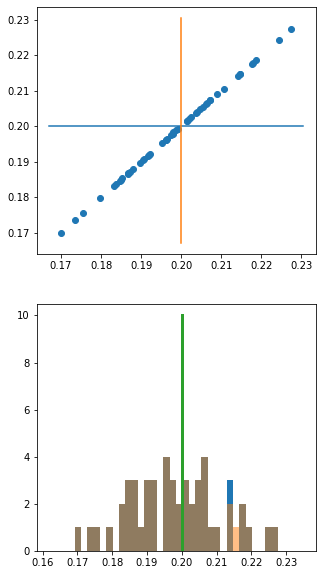

In [29]:
fig,ax = plt.subplots( 2, ndim, figsize=(5*ndim,5*2))

hbins=40
hmax = 10

for fi in range(ndim) :
    
    
    if ndim > 1 :
        thisax = ax[0][fi]
    else :
        thisax = ax[0]
        
    thisax.scatter( all_mean[fi,:n_for_plot], fit_results_mean_val[fi,:n_for_plot])
    xlow, xhigh = thisax.get_xlim()
    ylow, yhigh = thisax.get_ylim()
    print("  %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
              (fi, xlow, xhigh, ylow, yhigh))
    thisax.plot( (xlow, xhigh), (true_mu[fi], true_mu[fi]))
    thisax.plot( (true_mu[fi], true_mu[fi]), (ylow, yhigh))
    

    if ndim > 1 :
        thisax = ax[1][fi]
    else :
        thisax = ax[1]
    
    
    thisax.hist( fit_results_mean_val[fi,:n_for_plot], bins=hbins, 
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    thisax.hist( all_mean[fi,:n_for_plot], bins=hbins, alpha=0.5,
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    thisax.plot( (true_mu[fi],true_mu[fi]),(0,hmax), linewidth=3)
    

plt.show

In [30]:
if ndim > 1 :

    fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            ax[fi1][fi2].scatter( all_cov[fi1,fi2,:], fit_results_cov_val[fi1,fi2,:])
            xlow, xhigh = ax[fi1][fi2].get_xlim()
            ylow, yhigh = ax[fi1][fi2].get_ylim()
            print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
                  (fi1, fi2, xlow, xhigh, ylow, yhigh))
            ax[fi1][fi2].plot((xlow,xhigh),(true_cov[fi1][fi2], true_cov[fi1][fi2]))
            ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(ylow,yhigh))

    plt.show

In [31]:
if ndim > 1 :

    fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

    hbins=40
    hmax=10

    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            ax[fi1][fi2].hist( fit_results_cov_val[fi1,fi2,:], bins=hbins, 
                             range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
            ax[fi1][fi2].hist( all_cov[fi1,fi2,:], bins=hbins, alpha=0.5,
                             range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
            xlow, xhigh = ax[fi1][fi2].get_xlim()
            ylow, yhigh = ax[fi1][fi2].get_ylim()
            print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
                  (fi1, fi2, xlow, xhigh, ylow, yhigh))

            ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(0,hmax), linewidth=3)

    plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

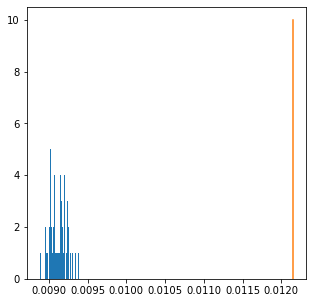

In [32]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))

hbins = 40
hmax = 10

for fi in range(ndim) :
    if ndim > 1 :
        thisax = ax[fi]
    else :
        thisax = ax
        
    thisax.hist( fit_results_mean_err[fi,:], bins=hbins )
    thisax.plot( (rms_mean[fi], rms_mean[fi]), (0,hmax) )
    
    
plt.show

In [33]:
fit_results_mean_err

array([[0.00924465, 0.00913897, 0.00923908, 0.00895532, 0.00927914,
        0.00907578, 0.00930489, 0.00905373, 0.00934192, 0.00915734,
        0.00920835, 0.00902908, 0.00924561, 0.00900942, 0.0092569 ,
        0.00888083, 0.00919941, 0.00923355, 0.00903282, 0.00897089,
        0.00904402, 0.00917491, 0.00938596, 0.00916674, 0.00898248,
        0.00907462, 0.00914821, 0.00906513, 0.00917951, 0.0089485 ,
        0.00915435, 0.00920822, 0.00916393, 0.00906432, 0.00916389,
        0.00907747, 0.00907186, 0.00909286, 0.00902857, 0.00925849,
        0.00914915, 0.00918483, 0.00912476, 0.00910918, 0.00910085,
        0.0090319 , 0.00920018, 0.00903101, 0.00901996, 0.009019  ]])

<function matplotlib.pyplot.show(close=None, block=None)>

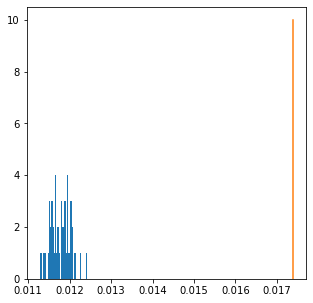

In [34]:
fig,ax = plt.subplots( 1, int((ndim*ndim+ndim)/2), figsize=(5*int((ndim*ndim+ndim)/2),5))

hbins = 40
hmax = 10

ai = 0

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        
        if ndim > 1 :
            thisax = ax[ai]
        else :
            thisax = ax

        thisax.hist( fit_results_cov_err[fi1,fi2,:], bins=hbins )
        thisax.plot( (rms_cov[fi1,fi2], rms_cov[fi1,fi2]), (0,hmax) )
        ai = ai + 1
    
plt.show

In [35]:
toy_fits_mu_rms = np.sqrt(np.var(fit_results_mean_val))
toy_fits_sig2_rms = np.sqrt(np.var(fit_results_cov_val))
toy_fits_mu_err_ave = np.average( fit_results_mean_err )
toy_fits_sig2_err_ave = np.average( fit_results_cov_err )

toy_fits_mu_ave = np.average( fit_results_mean_val )
toy_fits_sig2_ave = np.average( fit_results_cov_val )

print('\n\n')

print('  toy fits mu   ave. val  %7.4f,  true %7.4f' % (toy_fits_mu_ave, true_mu[0]))
print('  toy fits sig2 ave. val  %7.4f,  true %7.4f' % (toy_fits_sig2_ave, np.square(true_sig[0])))


print('\n\n')
print('  toy fits mu   RMS:  %7.4f,  ave fit err %7.4f' % (toy_fits_mu_rms, toy_fits_mu_err_ave))
print('  toy fits sig2 RMS:  %7.4f,  ave fit err %7.4f' % (toy_fits_sig2_rms, toy_fits_sig2_err_ave))
print('\n\n')




  toy fits mu   ave. val   0.1983,  true  0.2000
  toy fits sig2 ave. val   0.8323,  true  0.8100



  toy fits mu   RMS:   0.0129,  ave fit err  0.0091
  toy fits sig2 RMS:   0.0157,  ave fit err  0.0118





## Do the binned chi2 fits

In [36]:

if use_uniform_fit_hist_binning :
    
    fitting_hist_bins = np.linspace( uniform_fit_hist_xlow, uniform_fit_hist_xhigh, uniform_fit_hist_nbins+1 )
    fitting_hist_bin_widths = fitting_hist_bins[1:] - fitting_hist_bins[0:-1]
    fitting_hist_bin_centers = 0.5 * ( fitting_hist_bins[1:] + fitting_hist_bins[0:-1] )
    fitting_hist_n_bins = uniform_fit_hist_nbins
    
    print('\n\n Using uniform fit hist binning:  %.4f to %.4f in %d bins' % (
    uniform_fit_hist_xlow, uniform_fit_hist_xhigh, uniform_fit_hist_nbins))
    
    print('\n\n fitting_hist_bins calculated : %s\n\n' % str(fitting_hist_bins))
    
else :

    binning_file = '%s/binning.npy' % sample_input_dir

    with open(binning_file,'rb') as f :
        fitting_hist_bins = np.load(f)
        fitting_hist_bin_widths = np.load(f)
        fitting_hist_bin_centers = np.load(f)
        fitting_hist_n_bins = np.load(f)

    print('\n\n fitting_hist_bins read from file : %s\n\n' % str(fitting_hist_bins))
    
print(' fitting_hist_n_bins  %d' % fitting_hist_n_bins )




 Using uniform fit hist binning:  -3.0000 to 3.0000 in 20 bins


 fitting_hist_bins calculated : [-3.  -2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9
  1.2  1.5  1.8  2.1  2.4  2.7  3. ]


 fitting_hist_n_bins  20


 boot   0 weights: [0.112323   0.0971536  0.11644869 ... 0.11127081 0.04574313 0.06292559]
 boot   1 weights: [0.1185856  0.1113945  0.11069318 ... 0.11808441 0.08507084 0.09656268]
 boot   2 weights: [0.10265368 0.05805157 0.10821195 ... 0.05061074 0.07385811 0.08040215]
 boot   3 weights: [0.11026147 0.1161918  0.12366617 ... 0.1196295  0.11802304 0.10201659]
 boot   4 weights: [0.07940465 0.11655688 0.10993217 ... 0.1019639  0.08702939 0.09644829]
 boot   5 weights: [0.08826177 0.11149177 0.12410177 ... 0.09022115 0.05185091 0.12388526]
 boot   6 weights: [0.09677905 0.0831526  0.07398716 ... 0.09992586 0.11492649 0.08473453]
 boot   7 weights: [0.10384542 0.06662234 0.12274923 ... 0.0587593  0.11000024 0.11556993]
 boot   8 weights: [0.10604796 0.06507481 0.12037045 ... 0.11571613 0.09575082 0.08106568]
 boot   9 weights: [0.11637525 0.10003302 0.08724737 ... 0.12004753 0.09603769 0.12008132]
 boot  10 weights: [0.11668452 0.1210734  0.12003461 ... 0.1178095  0.10876313 0.08767863]

 boot  92 weights: [0.06100596 0.10199496 0.0961537  ... 0.06100596 0.11226777 0.10828702]
 boot  93 weights: [0.12117948 0.11959068 0.08901483 ... 0.07893104 0.12104732 0.0795524 ]
 boot  94 weights: [0.11313724 0.10055485 0.11140454 ... 0.07286491 0.08245258 0.06714275]
 boot  95 weights: [0.08398111 0.08155239 0.09818227 ... 0.10111796 0.08473619 0.06791851]
 boot  96 weights: [0.0349853  0.1191477  0.04621777 ... 0.07081476 0.09557159 0.03629948]
 boot  97 weights: [0.11459166 0.09352943 0.1216617  ... 0.12175256 0.12180318 0.09519953]
 boot  98 weights: [0.11213795 0.07889334 0.09349342 ... 0.11944509 0.10555637 0.04775486]
 boot  99 weights: [0.12466489 0.11202997 0.09623474 ... 0.11901772 0.07126896 0.12397834]
 boot 100 weights: [0.12525251 0.05557532 0.08159493 ... 0.10073411 0.11197788 0.10733539]
 boot 101 weights: [0.12242648 0.11942047 0.11502459 ... 0.12306279 0.11781597 0.12169117]
 boot 102 weights: [0.10943607 0.12063579 0.06754935 ... 0.08964122 0.11107747 0.08107569]

 boot 189 weights: [0.11333979 0.04759448 0.0954071  ... 0.12320359 0.12220013 0.02932829]
 boot 190 weights: [0.0940259  0.07857066 0.11916448 ... 0.10477552 0.11572367 0.07716671]
 boot 191 weights: [0.11009682 0.12003711 0.11260194 ... 0.1173645  0.0697244  0.12116431]
 boot 192 weights: [0.09837497 0.11348543 0.09450987 ... 0.11851423 0.08116411 0.08399754]
 boot 193 weights: [0.08882585 0.08753389 0.08309234 ... 0.10606251 0.12161622 0.10904478]
 boot 194 weights: [0.10615593 0.1250945  0.10615593 ... 0.09553587 0.11008955 0.12784779]
 boot 195 weights: [0.12732699 0.06497045 0.12632496 ... 0.12018013 0.1265926  0.11684689]
 boot 196 weights: [0.11401019 0.11159453 0.08655571 ... 0.08710525 0.10148139 0.06823326]
 boot 197 weights: [0.09581712 0.11652699 0.06464853 ... 0.07423729 0.0861668  0.11207481]
 boot 198 weights: [0.12581294 0.12461407 0.12336301 ... 0.06232752 0.08432422 0.08512789]
 boot 199 weights: [0.08681025 0.12109395 0.12018903 ... 0.12196244 0.06154029 0.07031426]

 boot 280 weights: [0.06754962 0.10724527 0.05477702 ... 0.09189193 0.09328993 0.09576291]
 boot 281 weights: [0.11749826 0.11091534 0.11154573 ... 0.11908245 0.12110255 0.076186  ]
 boot 282 weights: [0.12552175 0.11470424 0.05377992 ... 0.08373465 0.12404807 0.12499703]
 boot 283 weights: [0.10954812 0.11478504 0.12201508 ... 0.10027531 0.11738527 0.10500746]
 boot 284 weights: [0.10906706 0.11601423 0.0760167  ... 0.09879425 0.09388243 0.10650871]
 boot 285 weights: [0.08836587 0.11660841 0.12196753 ... 0.11791976 0.11491771 0.04409526]
 boot 286 weights: [0.12075731 0.12293891 0.12346543 ... 0.10145344 0.12159006 0.10975105]
 boot 287 weights: [0.11310081 0.12395563 0.09680837 ... 0.08578208 0.08781773 0.12111855]
 boot 288 weights: [0.12369423 0.10724825 0.02088585 ... 0.11816568 0.12458396 0.11314658]
 boot 289 weights: [0.11550219 0.10619509 0.12193358 ... 0.09251397 0.09893705 0.10713853]
 boot 290 weights: [0.05887616 0.0497259  0.07363272 ... 0.07809361 0.09080293 0.07778513]

 boot 380 weights: [0.11487447 0.12189358 0.07020933 ... 0.12030163 0.09598568 0.11810029]
 boot 381 weights: [0.12141109 0.11711193 0.09647041 ... 0.11567745 0.0776026  0.06828796]
 boot 382 weights: [0.10114374 0.1026128  0.1262016  ... 0.07025649 0.05424483 0.05629758]
 boot 383 weights: [0.1197547  0.12181195 0.12178877 ... 0.10305166 0.06401138 0.12051693]
 boot 384 weights: [0.08254558 0.10896964 0.07669973 ... 0.11368569 0.09767861 0.07669973]
 boot 385 weights: [0.07127653 0.11798181 0.12641371 ... 0.09869118 0.1218136  0.12307626]
 boot 386 weights: [0.1219277  0.11821247 0.10481429 ... 0.08833122 0.12195841 0.09756397]
 boot 387 weights: [0.0877707  0.10192285 0.10802944 ... 0.07136876 0.05780393 0.11757337]
 boot 388 weights: [0.09530194 0.11332274 0.11302167 ... 0.09842852 0.09334878 0.11332274]
 boot 389 weights: [0.10112608 0.12385733 0.10112608 ... 0.10836364 0.12211923 0.11965333]
 boot 390 weights: [0.10344675 0.1124007  0.10344675 ... 0.12611665 0.07139761 0.09802821]

 boot 481 weights: [0.07888806 0.12096153 0.10375295 ... 0.11285925 0.12221469 0.11518192]
 boot 482 weights: [0.05270448 0.09730913 0.11849907 ... 0.04505406 0.10932127 0.10769664]
 boot 483 weights: [0.1003553  0.07004029 0.09706875 ... 0.06569849 0.06799473 0.07248642]
 boot 484 weights: [0.10203178 0.11929126 0.10466964 ... 0.05313175 0.09360206 0.12130001]
 boot 485 weights: [0.0845454  0.1110926  0.08688119 ... 0.07016963 0.05362767 0.11790833]
 boot 486 weights: [0.03222531 0.11860302 0.08238251 ... 0.07965495 0.11027579 0.10687037]
 boot 487 weights: [0.12522882 0.09976727 0.08829427 ... 0.06342552 0.09915099 0.10040646]
 boot 488 weights: [0.120569   0.11944512 0.09948368 ... 0.11579257 0.0729413  0.12121392]
 boot 489 weights: [0.10308255 0.05449322 0.08732275 ... 0.08930977 0.10066522 0.11824625]
 boot 490 weights: [0.12504324 0.12186636 0.12322913 ... 0.11173727 0.12539331 0.12470144]
 boot 491 weights: [0.11824638 0.09727263 0.1062167  ... 0.10145504 0.0740875  0.11298296]

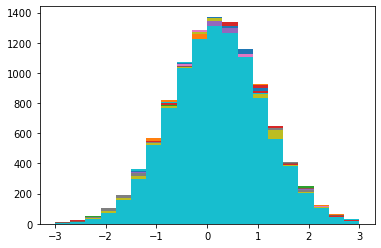

In [37]:
boot_hist_content = np.zeros( shape=(n_samples, fitting_hist_n_bins ))


simple_calc_mean = np.zeros( n_samples )
simple_calc_cov  = np.zeros( n_samples )

of_weight_sum = np.zeros( n_samples )


for bi in range(n_samples) :

    
    rd = read_sample( sample_input_dir, bi )

    ngen_true = rd['ngen_true']
    ngen_train = rd['ngen_train']

    true_pts = rd['true_pts']
    true_det_pts = rd['true_det_pts']
    train_pts = rd['train_pts']
    train_det_pts = rd['train_det_pts']
    
    
            
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, bi)

    if not exists(fname) :  
        print('\n\n *** Missing %s' % fname )
        continue

    with open(fname,'rb') as f :            

        final_push_weights_scaled = np.load(f)
        print(' boot %3d weights: ' % bi, end='')
        print( final_push_weights_scaled)

        of_weight_sum[bi] = np.sum( final_push_weights_scaled )

        hist_content,_,_ = plt.hist( train_pts[:,0], bins=fitting_hist_bins, weights=final_push_weights_scaled )
        #print(hist_content)
        boot_hist_content[bi,:] = hist_content


        mean_cov = calc_mean_cov( final_push_weights_scaled, 0, 0 )

        simple_calc_mean[bi] = mean_cov['mean_x1']
        simple_calc_cov[bi]  = mean_cov['cov_x1x2']
        
        
        

<function matplotlib.pyplot.show(close=None, block=None)>

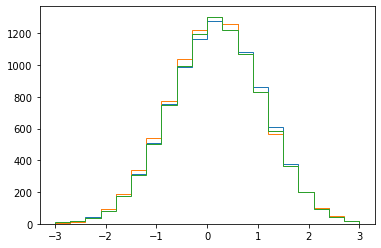

In [38]:
plt.stairs( boot_hist_content[0,:], edges=fitting_hist_bins )
plt.stairs( boot_hist_content[1,:], edges=fitting_hist_bins )
plt.stairs( boot_hist_content[2,:], edges=fitting_hist_bins )
plt.show

In [39]:
hist_nbins = fitting_hist_n_bins


hist_corr_mat = np.zeros( shape=(hist_nbins, hist_nbins) )
hist_cov_mat = np.zeros( shape=(hist_nbins, hist_nbins) )

for bi in range(hist_nbins) :
    
    for bj in range( hist_nbins ) :
        
        ccm = np.corrcoef( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
        cvm =      np.cov( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
        
        hist_corr_mat[bi,bj] = ccm[0,1]
        
        hist_cov_mat[bi,bj] = cvm[0,1]
        
        if bi == bj : hist_cov_mat[bi,bj] = hist_cov_mat[bi,bj] + diagonal_constant
        

In [40]:
hist_corr_mat[0,hist_nbins-1] = -1.

In [41]:
min_cov_element = np.min(hist_cov_mat)
max_cov_element = np.max(hist_cov_mat)
print('\n\n Min and max elements of cov mat:  %.2f , %.2f\n\n' % (min_cov_element, max_cov_element))
hist_cov_mat_copy = np.copy( hist_cov_mat )
hist_cov_mat_copy[0,hist_nbins-1] = -1. * max_cov_element



 Min and max elements of cov mat:  -201.35 , 708.26




<function matplotlib.pyplot.show(close=None, block=None)>

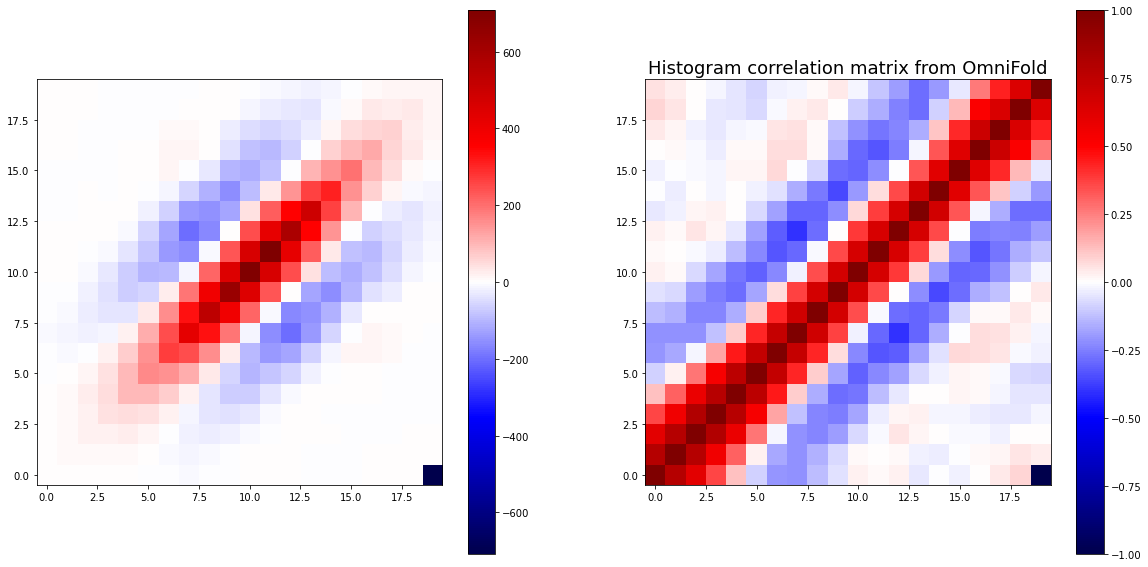

In [42]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_corr_mat, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )



ax[1].set_title('Histogram correlation matrix from OmniFold', fontsize=18)



plt.show

In [43]:
hist_cov_inv = np.linalg.inv( hist_cov_mat )
cov_inv_test = np.matmul( hist_cov_mat, hist_cov_inv )

In [44]:
hist_cov_mat_diagonal = np.copy( hist_cov_mat )
for bi in range(hist_nbins) :
    for bj in range(hist_nbins) :
        if bi != bj : hist_cov_mat_diagonal[bi,bj] = 0.

In [45]:
hist_cov_inv_diagonal = np.linalg.inv( hist_cov_mat_diagonal )

In [46]:
ci_min = np.min(hist_cov_inv)
ci_max = np.max(hist_cov_inv)
print('\n\n min and max of covariance matrix inverse:  %.2f  %.2f\n\n' % (ci_min, ci_max))

hist_cov_inv_copy = np.copy( hist_cov_inv )
hist_cov_inv_copy[0,hist_nbins-1] = -1. * ci_max



 min and max of covariance matrix inverse:  -0.16  0.48




<function matplotlib.pyplot.show(close=None, block=None)>

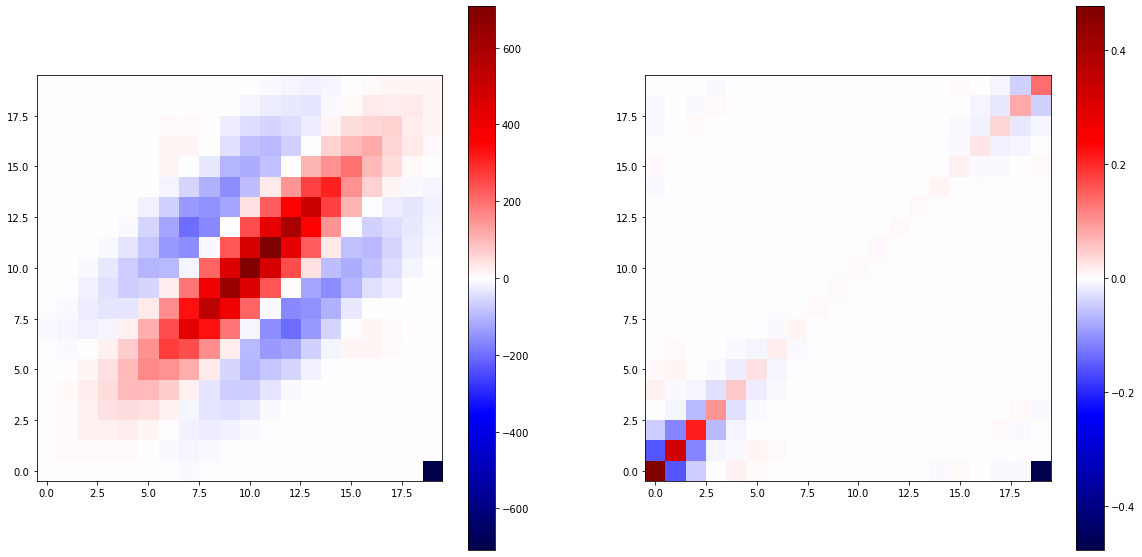

In [47]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_cov_inv_copy, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )







plt.show

In [48]:

hist_cov_pinv = np.linalg.pinv( hist_cov_mat, rcond_val )


In [49]:
hist_cov_pinv_minus_inv = hist_cov_pinv - hist_cov_inv
cov_pinv_test = np.matmul( hist_cov_mat, hist_cov_pinv )

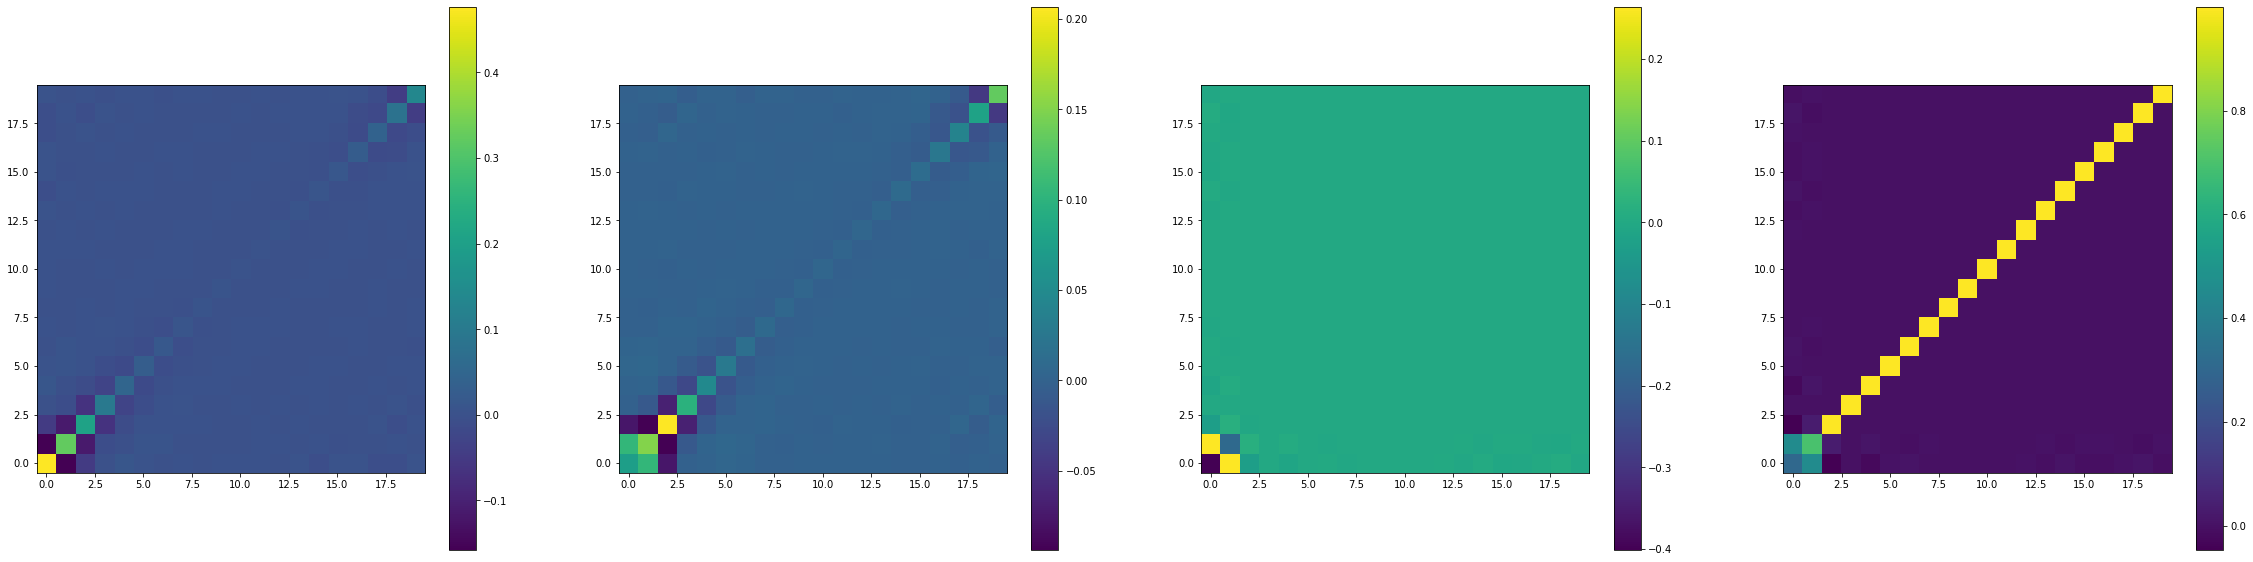

In [50]:
fig,ax = plt.subplots( 1, 4, figsize=(4*10,10))



im_covinv = ax[0].imshow(hist_cov_inv, origin='lower')
ax[0].figure.colorbar( im_covinv, ax=ax[0] )

im_covpinv = ax[1].imshow(hist_cov_pinv, origin='lower')
ax[1].figure.colorbar( im_covpinv, ax=ax[1] )

im_covpinvdiff = ax[2].imshow(hist_cov_pinv_minus_inv, origin='lower')
ax[2].figure.colorbar( im_covpinvdiff, ax=ax[2] )

im_pinv_test = ax[3].imshow(cov_pinv_test, origin='lower')
ax[3].figure.colorbar( im_pinv_test, ax=ax[3] )



In [51]:
cpi_min = np.min(hist_cov_pinv)
cpi_max = np.max(hist_cov_pinv)
print('\n\n min and max of covariance matrix pseudo inverse:  %.2f  %.2f\n\n' % (cpi_min, cpi_max))

hist_cov_pinv_copy = np.copy( hist_cov_pinv )
hist_cov_pinv_copy[0,hist_nbins-1] = -1. * cpi_max




 min and max of covariance matrix pseudo inverse:  -0.09  0.21




<function matplotlib.pyplot.show(close=None, block=None)>

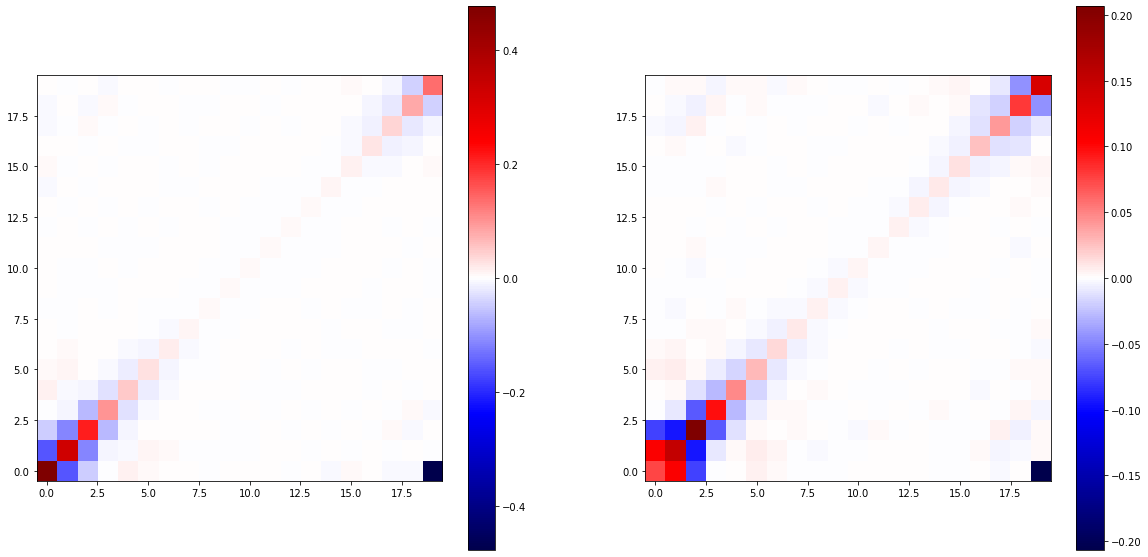

In [52]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_inv_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_cov_pinv_copy, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )







plt.show

## Set up a Minuit fit

Used this example from Glen Cowan as a starting point: https://github.com/KMISchool2022/histFit/blob/main/histFit.ipynb


In [53]:
import iminuit
from iminuit import Minuit
import scipy.stats as stats
from scipy.stats import chi2

from scipy import special


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [54]:


def f_bin_center_approx(x, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    
    model_norm =  1. / ( np.sqrt( 2 * 3.14159265 * sigma2 ) )
    
    model_pred = model_norm * np.exp( -0.5 * np.square((x - mu))/sigma2 )
    
    return theta * model_pred



def f_integral_within_bin(x_low, x_high, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    sigma = np.sqrt(sigma2)
    
    model_pred = 0.5 * ( 1. + special.erf( (x_high - mu )/(sigma*np.sqrt(2.)) ) ) - 0.5 * ( 1. + special.erf( (x_low - mu )/(sigma*np.sqrt(2.)) ) )
    
    return theta * model_pred



class ChiSquared:                   # function to be minimized

    def __init__(self, xHist, bin_edges, covMatInv, fitType, verbose=0):
        self.setData(xHist, bin_edges, covMatInv, verbose)
        self.fitType = fitType
        
    def setData(self, xHist, bin_edges, covMatInv, verbose):
        numVal = np.sum(xHist)
        numBins = len(xHist)
        binLowEdge = np.zeros(numBins)
        binHighEdge = np.zeros(numBins)
        for bi in range(numBins) :
            binLowEdge[bi] = bin_edges[bi]
            binHighEdge[bi] = bin_edges[bi+1]
        binWidth = binHighEdge - binLowEdge
        binCenter = 0.5 * (binLowEdge + binHighEdge)
            
        self.data = xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv

        if verbose > 0 :
            print('\n\n setData:')
            print('  numVal: %12.1f  numBins = %d' % (numVal, numBins))
            print('  binLowEdge: ', end='' )
            print('  fitType: %s' % fitType )
            print( binLowEdge)


        
    def chi2LS_integral_within_bin(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_integral_within_bin(binLowEdge, binHighEdge, par)
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


    def chi2LS_bin_center_approx(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_bin_center_approx(binCenter, par) * binWidth
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


        
    def __call__(self, par):
        if fitType == 'integral within bin' :
            return self.chi2LS_integral_within_bin(par)
        elif fitType == 'bin center approximation' :
            return self.chi2LS_bin_center_approx(par)
        else :
            print('\n\n *** Unknown fitType :  %s\n\n' % fitType )
            return -1

        
        

In [55]:

chi2_fit_mu_val = np.zeros( len(boot_hist_content) )
chi2_fit_mu_err = np.zeros( len(boot_hist_content) )

chi2_fit_sig2_val = np.zeros( len(boot_hist_content) )
chi2_fit_sig2_err = np.zeros( len(boot_hist_content) )

chi2_fit_diag_mu_val = np.zeros( len(boot_hist_content) )
chi2_fit_diag_mu_err = np.zeros( len(boot_hist_content) )

chi2_fit_diag_sig2_val = np.zeros( len(boot_hist_content) )
chi2_fit_diag_sig2_err = np.zeros( len(boot_hist_content) )



for si in range( len(boot_hist_content) ) :
    
    # Initialize Minuit and set up fit:
    theta = 1
    mu = 0.2
    sigma2 = 0.81
    #fitType = 'full cov'

    parin   = np.array([theta, mu, sigma2])      # initial values (here = true)
    parname = ['theta', 'mu', 'sigma2']
    parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma^2$']
    parstep = np.array([0.01, 0.1, 0.1])           # initial setp sizes
    parfix  = [False, False, False]            # change to fix/free param.
    parlim  = [(0.5, 1.5), (None, None), (0., None)]

    chisq = ChiSquared( boot_hist_content[si], fitting_hist_bins, hist_cov_pinv, fitType)
    chisq_diag = ChiSquared( boot_hist_content[si], fitting_hist_bins, hist_cov_inv_diagonal, fitType)


    m = Minuit(chisq, parin, name=parname)
    m.errors = parstep
    m.fixed = parfix
    m.limits = parlim
    m.errordef = 1.0                      # errors from chi2 = chi2min + 1


    m_diag = Minuit(chisq_diag, parin, name=parname)
    m_diag.errors = parstep
    m_diag.fixed = parfix
    m_diag.limits = parlim
    m_diag.errordef = 1.0                      # errors from chi2 = chi2min + 1    
    
    
    # do the fit, get errors, extract results
    m.migrad()                                        # minimize -logL
    parhat = m.values                                 # max-likelihood estimates
    sigma_parhat = m.errors                           # standard deviations
    cov = m.covariance                                # covariance matrix
    rho = m.covariance.correlation()                  # correlation coeffs.

    m_diag.migrad()                                        # minimize -logL
    parhat_diag = m_diag.values                                 # max-likelihood estimates
    sigma_parhat_diag = m_diag.errors                           # standard deviations
    cov_diag = m_diag.covariance                                # covariance matrix
    rho_diag = m_diag.covariance.correlation()                  # correlation coeffs.

    
    chi2_fit_mu_val[si] = parhat[1]
    chi2_fit_mu_err[si] = sigma_parhat[1]

    chi2_fit_sig2_val[si] = parhat[2]
    chi2_fit_sig2_err[si] = sigma_parhat[2]

    
    chi2_fit_diag_mu_val[si] = parhat_diag[1]
    chi2_fit_diag_mu_err[si] = sigma_parhat_diag[1]

    chi2_fit_diag_sig2_val[si] = parhat_diag[2]
    chi2_fit_diag_sig2_err[si] = sigma_parhat_diag[2]

    
    

    
    
    
    print(' %3d : mu %8.4f +/- %8.4f  (%8.4f +/- %8.4f)    sig2 %8.4f +/- %8.4f  (%8.4f +/- %8.4f)' %
          (si, 
           parhat[1], sigma_parhat[1],
           parhat_diag[1], sigma_parhat_diag[1],
           parhat[2], sigma_parhat[2],
           parhat_diag[2], sigma_parhat_diag[2],
          )
         )
    

   0 : mu   0.1891 +/-   0.0122  (  0.1929 +/-   0.0069)    sig2   0.8427 +/-   0.0178  (  0.8470 +/-   0.0094)
   1 : mu   0.1751 +/-   0.0121  (  0.1734 +/-   0.0068)    sig2   0.8347 +/-   0.0173  (  0.8340 +/-   0.0092)
   2 : mu   0.1906 +/-   0.0123  (  0.1913 +/-   0.0070)    sig2   0.8243 +/-   0.0180  (  0.8279 +/-   0.0095)
   3 : mu   0.1936 +/-   0.0121  (  0.1951 +/-   0.0068)    sig2   0.7981 +/-   0.0176  (  0.7932 +/-   0.0092)
   4 : mu   0.1724 +/-   0.0122  (  0.1734 +/-   0.0069)    sig2   0.8394 +/-   0.0175  (  0.8471 +/-   0.0093)
   5 : mu   0.1913 +/-   0.0121  (  0.1905 +/-   0.0068)    sig2   0.8207 +/-   0.0173  (  0.8221 +/-   0.0092)
   6 : mu   0.2074 +/-   0.0123  (  0.2072 +/-   0.0070)    sig2   0.8434 +/-   0.0180  (  0.8453 +/-   0.0096)
   7 : mu   0.1838 +/-   0.0120  (  0.1859 +/-   0.0068)    sig2   0.8242 +/-   0.0177  (  0.8247 +/-   0.0092)
   8 : mu   0.1901 +/-   0.0123  (  0.1918 +/-   0.0069)    sig2   0.8581 +/-   0.0180  (  0.8601 +/-   

 111 : mu   0.2038 +/-   0.0121  (  0.2018 +/-   0.0069)    sig2   0.8323 +/-   0.0177  (  0.8351 +/-   0.0094)
 112 : mu   0.2131 +/-   0.0120  (  0.2127 +/-   0.0068)    sig2   0.8326 +/-   0.0174  (  0.8360 +/-   0.0092)
 113 : mu   0.2046 +/-   0.0123  (  0.2061 +/-   0.0070)    sig2   0.8080 +/-   0.0180  (  0.8049 +/-   0.0094)
 114 : mu   0.1919 +/-   0.0118  (  0.1932 +/-   0.0067)    sig2   0.8284 +/-   0.0176  (  0.8298 +/-   0.0091)
 115 : mu   0.2072 +/-   0.0120  (  0.2061 +/-   0.0068)    sig2   0.8268 +/-   0.0173  (  0.8235 +/-   0.0091)
 116 : mu   0.2030 +/-   0.0120  (  0.2016 +/-   0.0068)    sig2   0.8141 +/-   0.0172  (  0.8102 +/-   0.0090)
 117 : mu   0.1954 +/-   0.0120  (  0.1960 +/-   0.0068)    sig2   0.8581 +/-   0.0183  (  0.8550 +/-   0.0095)
 118 : mu   0.2172 +/-   0.0121  (  0.2165 +/-   0.0068)    sig2   0.8298 +/-   0.0176  (  0.8264 +/-   0.0093)
 119 : mu   0.1983 +/-   0.0121  (  0.1982 +/-   0.0069)    sig2   0.8336 +/-   0.0181  (  0.8316 +/-   

 226 : mu   0.2031 +/-   0.0121  (  0.2016 +/-   0.0068)    sig2   0.8117 +/-   0.0168  (  0.8155 +/-   0.0090)
 227 : mu   0.2033 +/-   0.0122  (  0.2040 +/-   0.0069)    sig2   0.8463 +/-   0.0178  (  0.8492 +/-   0.0094)
 228 : mu   0.1988 +/-   0.0120  (  0.2026 +/-   0.0068)    sig2   0.7929 +/-   0.0175  (  0.7911 +/-   0.0091)
 229 : mu   0.2019 +/-   0.0121  (  0.2018 +/-   0.0069)    sig2   0.8548 +/-   0.0175  (  0.8573 +/-   0.0093)
 230 : mu   0.2096 +/-   0.0121  (  0.2129 +/-   0.0068)    sig2   0.8144 +/-   0.0177  (  0.8182 +/-   0.0093)
 231 : mu   0.1902 +/-   0.0120  (  0.1899 +/-   0.0068)    sig2   0.8262 +/-   0.0174  (  0.8278 +/-   0.0092)
 232 : mu   0.1888 +/-   0.0122  (  0.1876 +/-   0.0069)    sig2   0.8336 +/-   0.0177  (  0.8286 +/-   0.0093)
 233 : mu   0.1840 +/-   0.0120  (  0.1853 +/-   0.0068)    sig2   0.8060 +/-   0.0176  (  0.8074 +/-   0.0092)
 234 : mu   0.2157 +/-   0.0121  (  0.2175 +/-   0.0068)    sig2   0.8116 +/-   0.0174  (  0.8078 +/-   

 339 : mu   0.2208 +/-   0.0121  (  0.2200 +/-   0.0068)    sig2   0.8264 +/-   0.0177  (  0.8214 +/-   0.0092)
 340 : mu   0.1883 +/-   0.0118  (  0.1915 +/-   0.0067)    sig2   0.8106 +/-   0.0170  (  0.8126 +/-   0.0089)
 341 : mu   0.2163 +/-   0.0122  (  0.2179 +/-   0.0069)    sig2   0.8491 +/-   0.0186  (  0.8456 +/-   0.0097)
 342 : mu   0.1900 +/-   0.0121  (  0.1861 +/-   0.0068)    sig2   0.8014 +/-   0.0170  (  0.8018 +/-   0.0090)
 343 : mu   0.2019 +/-   0.0123  (  0.1982 +/-   0.0070)    sig2   0.8416 +/-   0.0179  (  0.8404 +/-   0.0094)
 344 : mu   0.1932 +/-   0.0120  (  0.1943 +/-   0.0068)    sig2   0.8280 +/-   0.0173  (  0.8291 +/-   0.0092)
 345 : mu   0.2065 +/-   0.0120  (  0.2039 +/-   0.0068)    sig2   0.8166 +/-   0.0174  (  0.8196 +/-   0.0092)
 346 : mu   0.1982 +/-   0.0121  (  0.1944 +/-   0.0069)    sig2   0.8110 +/-   0.0175  (  0.8076 +/-   0.0092)
 347 : mu   0.2141 +/-   0.0122  (  0.2143 +/-   0.0069)    sig2   0.8258 +/-   0.0176  (  0.8325 +/-   

 451 : mu   0.2119 +/-   0.0122  (  0.2127 +/-   0.0069)    sig2   0.8444 +/-   0.0179  (  0.8476 +/-   0.0095)
 452 : mu   0.1785 +/-   0.0122  (  0.1784 +/-   0.0069)    sig2   0.8156 +/-   0.0175  (  0.8157 +/-   0.0092)
 453 : mu   0.2171 +/-   0.0120  (  0.2146 +/-   0.0068)    sig2   0.8509 +/-   0.0172  (  0.8524 +/-   0.0092)
 454 : mu   0.1863 +/-   0.0121  (  0.1850 +/-   0.0069)    sig2   0.8029 +/-   0.0174  (  0.8031 +/-   0.0091)
 455 : mu   0.1875 +/-   0.0121  (  0.1897 +/-   0.0068)    sig2   0.8471 +/-   0.0181  (  0.8499 +/-   0.0094)
 456 : mu   0.1995 +/-   0.0118  (  0.2000 +/-   0.0067)    sig2   0.8175 +/-   0.0178  (  0.8131 +/-   0.0092)
 457 : mu   0.2021 +/-   0.0122  (  0.2019 +/-   0.0069)    sig2   0.8381 +/-   0.0184  (  0.8299 +/-   0.0096)
 458 : mu   0.2038 +/-   0.0120  (  0.2035 +/-   0.0068)    sig2   0.8318 +/-   0.0176  (  0.8341 +/-   0.0093)
 459 : mu   0.1900 +/-   0.0122  (  0.1871 +/-   0.0069)    sig2   0.8345 +/-   0.0183  (  0.8261 +/-   

<function matplotlib.pyplot.show(close=None, block=None)>

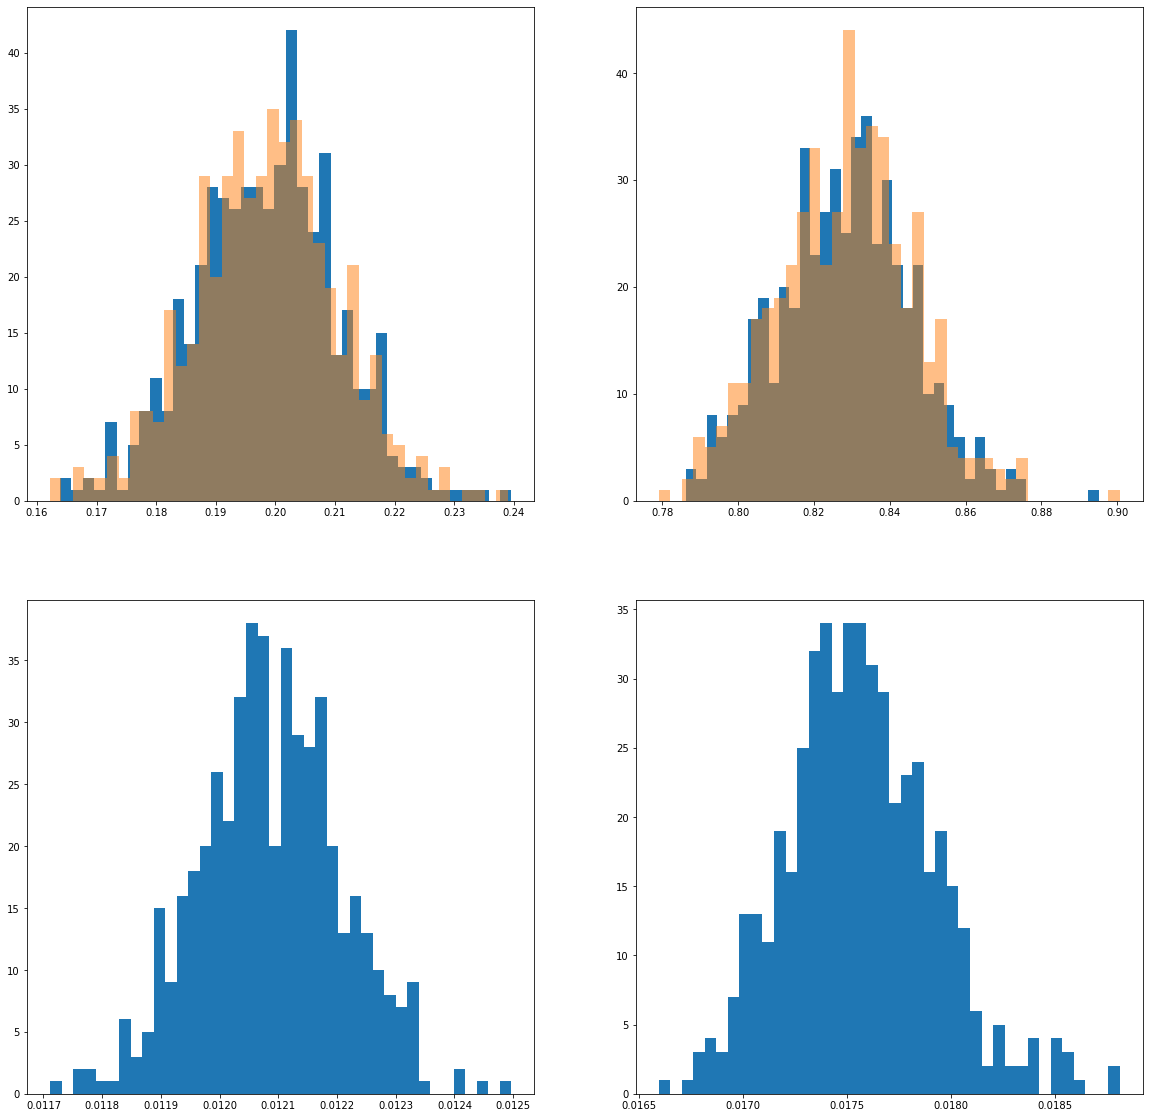

In [56]:
fig,ax = plt.subplots( 2, 2, figsize=(2*10,2*10))

ax[0][0].hist( chi2_fit_mu_val, bins=40 )
ax[0][0].hist( chi2_fit_diag_mu_val, bins=40, alpha=0.5 )

ax[0][1].hist( chi2_fit_sig2_val, bins=40 )
ax[0][1].hist( chi2_fit_diag_sig2_val, bins=40, alpha=0.5 )


ax[1][0].hist( chi2_fit_mu_err, bins=40 )

ax[1][1].hist( chi2_fit_sig2_err, bins=40 )


plt.show

In [57]:


mean_mu = np.mean( chi2_fit_mu_val )
mean_mu2 = np.mean( chi2_fit_mu_val * chi2_fit_mu_val )
rms_mu = np.sqrt( mean_mu2 - mean_mu * mean_mu )

mean_sig2 = np.mean( chi2_fit_sig2_val )
mean_sig22 = np.mean( chi2_fit_sig2_val * chi2_fit_sig2_val )
rms_sig2 = np.sqrt( mean_sig22 - mean_sig2 * mean_sig2 )

mean_mu_fit_err = np.mean( chi2_fit_mu_err )
mean_sig2_fit_err = np.mean( chi2_fit_sig2_err )





mean_mu_diag = np.mean( chi2_fit_diag_mu_val )
mean_mu2_diag = np.mean( chi2_fit_diag_mu_val * chi2_fit_diag_mu_val )
rms_mu_diag = np.sqrt( mean_mu2_diag - mean_mu_diag * mean_mu_diag )

mean_sig2_diag = np.mean( chi2_fit_diag_sig2_val )
mean_sig22_diag = np.mean( chi2_fit_diag_sig2_val * chi2_fit_diag_sig2_val )
rms_sig2_diag = np.sqrt( mean_sig22_diag - mean_sig2_diag * mean_sig2_diag )

mean_mu_fit_err_diag = np.mean( chi2_fit_diag_mu_err )
mean_sig2_fit_err_diag = np.mean( chi2_fit_diag_sig2_err )




print('\n\n')
print(' mean: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
      (mean_mu, rms_mu, mean_mu_fit_err,    mean_mu_diag, rms_mu_diag, mean_mu_fit_err_diag))
print(' sig2: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
      (mean_sig2, rms_sig2, mean_sig2_fit_err,   mean_sig2_diag, rms_sig2_diag, mean_sig2_fit_err_diag))
print('\n\n')





 mean:  0.1986, rms  0.0120, mean fit err  0.0121  |  diag. chi2 fit    0.1984, rms  0.0122, mean fit err  0.0068
 sig2:  0.8282, rms  0.0175, mean fit err  0.0176  |  diag. chi2 fit    0.8285, rms  0.0179, mean fit err  0.0093





In [58]:
with open( '%s/chi2-fit-results.npy' % input_dir, 'wb' ) as f :
    np.save( f, chi2_fit_mu_val )
    np.save( f, chi2_fit_sig2_val )
    np.save( f, chi2_fit_mu_err )
    np.save( f, chi2_fit_sig2_err )
    np.save( f, chi2_fit_diag_mu_val )
    np.save( f, chi2_fit_diag_sig2_val )
    np.save( f, chi2_fit_diag_mu_err )
    np.save( f, chi2_fit_diag_sig2_err )
    
    
    
    